# Adaptive Data Debiasing through Bounded Exploraiton and Fairness

This code is under the pure exploration baseline model

Define true, initial, and other hyper-parameters 

In [256]:
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from statistics import median
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Defining True Parameters
mu_1_true_group1 = 10
mu_0_true_group1 = 7
sd = 1 

# Defining Initial Assumed Parameters
mu1_init_group1 = 9
mu0_init_group1 = 6

true_pop_prob_group1 = 0.5
exploration_porb_group1 = 1
generating_samples_group1 = 150000
existing_1_customers_group1 = 1000
existing_0_customers_group1 = 1000
batchsize = 800
reference_quantile = 0.5

TP_group1 = 0
FP_group1 = 0
FN_group1 = 0
TN_group1 = 0

TP_oracle_group1 = 0 
FP_oracle_group1 = 0
FN_oracle_group1 = 0
TN_oracle_group1 = 0

Generate initial and incoming data and forget initial/true parameters defined above. From now on, the true and initial parameters are obtained by fitting data into distributions. 

In [257]:
# Generate initial data
data_1 = np.random.normal(mu1_init_group1,sd,size=existing_1_customers_group1)
data_0 = np.random.normal(mu0_init_group1,sd,size=existing_0_customers_group1)

# Generate incoming true data
label1 = np.random.normal(mu_1_true_group1,sd,size =int(generating_samples_group1*(1-true_pop_prob_group1)))
label0 = np.random.normal(mu_0_true_group1,sd,size =int(generating_samples_group1*true_pop_prob_group1))

# Obtain initial parameters via initial data
mu_1_init_group1, sd = norm.fit(data_1, fscale = sd)
mu_0_init_group1, sd = norm.fit(data_0, fscale = sd)

mu_1_group1 = mu_1_init_group1
mu_0_group1 = mu_0_init_group1

# Obtain true parameters via incoming true data
mu_1_true_group1, sd = norm.fit(label1, fscale = sd)
mu_0_true_group1, sd = norm.fit(label0, fscale = sd)
print ("Initial parameter mu_1_group1 is ", mu_1_group1)
print ("Initial parameter mu_0_group1 is ", mu_0_group1)
print ("True parameter mu_1_true_group1 is ", mu_1_true_group1)
print ("True parameter mu_0_true_group1 is ", mu_0_true_group1)

Initial parameter mu_1_group1 is  8.984806075822952
Initial parameter mu_0_group1 is  5.952656959402886
True parameter mu_1_true_group1 is  9.996403572635218
True parameter mu_0_true_group1 is  6.999165963071546


Find the initial classifier threshold and oracle classifier threshold from the initial data and incoming true data respectively. In addition, for the pure exploration baseline model, there is no LB and UB.

In [258]:
# Find the initial classifier through Logistic Regression model
X_train = np.append(data_1, data_0).reshape(-1,1)
y_train = np.append(np.ones(len(data_1)),np.zeros(len(data_0))).reshape(-1,)
classifier = LogisticRegression().fit(X_train, y_train)

# Obtain numerical value for classifier_group1 by solving
# 0 = beta_0 + beta_1 * classifier_group1 in logistic regression
classifier_group1 = float(-classifier.intercept_/classifier.coef_)
print ("Initial classifier is ", classifier_group1)

# Find oracle classifier and its value
X_train_oracle = np.append(label1, label0).reshape(-1,1)
y_train_oracle = np.append(np.ones(len(label1)),np.zeros(len(label0))).reshape(-1,)
classifier_oracle = LogisticRegression().fit(X_train_oracle, y_train_oracle)
classifier_oracle_value = float(-classifier_oracle.intercept_/classifier_oracle.coef_)
print ("Oracle classifier is ", classifier_oracle_value)

Initial classifier is  7.466538422717098
Oracle classifier is  8.498061327457044


Build the info dataframe, which contains the information of ('True Label','Values','Decision','RP_1','RP_0', 'Classifier','Regret','Explore_Prob')

In [259]:
info_group1 = pd.DataFrame(columns = ['True Label','Values','Decision','RP_1','RP_0',
                                      'Classifier','Regret','Explore_Prob'])

# Assign feature values to the dataframe
info_group1['Values'] = np.append(label1, label0)
# Assign true labels to the dataframe
info_group1.loc[0:len(label1),'True Label'] = 1
info_group1.loc[len(label1):,'True Label'] = 0
# Shuffle the dataframe
info_group1 = shuffle(info_group1)
# Resign the index 
info_group1.reset_index(inplace=True, drop=True)

Perform the parameter update once the size of data falling into the updating range reaches the batchsize

In [260]:
i = 0
# Create loop for updating
while (i <= len(info_group1)-1):
    data_1_trun = []
    data_0_trun = []
    
    # find quantile of reference point including label 0 tail
    portion_right_0 = norm.sf(norm.ppf(reference_quantile,mu_0_group1,sd),mu_0_group1,sd) 
    portion_left_0 = 1 - portion_right_0
    
    portion_right_1 = norm.sf(norm.ppf(reference_quantile,mu_1_group1,sd),mu_1_group1,sd) 
    portion_left_1 = 1 - portion_right_1
    
    k = len(data_0_trun)
    #loop into each batch
    while ((k <= batchsize) & (i <= len(info_group1)-1)):

        # Make decisions
        if (classifier.predict([[info_group1.loc[i,'Values']]]) == 1):
            info_group1.loc[i,'Decision'] = 1
        elif (classifier.predict([[info_group1.loc[i,'Values']]]) == 0) & (np.random.uniform(size=1)<=exploration_porb_group1):
            info_group1.loc[i,'Decision'] = 1
        else:
            info_group1.loc[i,'Decision'] = 0   
    
        # Record confusion matrix
        if (info_group1.loc[i,'True Label']==1) & (info_group1.loc[i,'Decision']==1):
            TP_group1 += 1
        elif (info_group1.loc[i,'True Label']==1) & (info_group1.loc[i,'Decision']==0):
            FN_group1 += np.exp(info_group1.loc[i,'Values'] + 4*sd - mu_1_true_group1)
            
        elif (info_group1.loc[i,'True Label']==0) & (info_group1.loc[i,'Decision']==0):
            TN_group1 += 1
        else:
            FP_group1 += np.exp(4*sd + mu_0_true_group1 - info_group1.loc[i,'Values'])
            
    
        # Record oracle matrix
        if (classifier_oracle.predict([[info_group1.loc[i,'Values']]]) == 1) & (info_group1.loc[i,'True Label']==1):
            TP_oracle_group1 += 1
        elif (classifier_oracle.predict([[info_group1.loc[i,'Values']]]) == 1) & (info_group1.loc[i,'True Label']==0):
            FP_oracle_group1 += np.exp(4*sd + mu_0_true_group1 - info_group1.loc[i,'Values'])
            
        elif (classifier_oracle.predict([[info_group1.loc[i,'Values']]]) == 0) & (info_group1.loc[i,'True Label']==1):
            FN_oracle_group1 += np.exp(info_group1.loc[i,'Values'] + 4*sd - mu_1_true_group1)
            
        else:
            TN_oracle_group1 += 1
    
        
        # Record label 1 information for updating
        if (info_group1.loc[i,'True Label']==1) & ((info_group1.loc[i,'Decision']==1) or (info_group1.loc[i,'Decision']==2)):
            data_1 = np.append(data_1, info_group1.loc[i,'Values'])
            if ((classifier.predict([[info_group1.loc[i,'Values']]]) == 0 & (info_group1.loc[i,'Decision']==1)) 
               or (classifier.predict([[info_group1.loc[i,'Values']]]) == 1 & (info_group1.loc[i,'Decision']==1) & (np.random.uniform(size=1)<=exploration_porb_group1))):
                data_1_trun = np.append(data_1_trun, info_group1.loc[i,'Values'])
        else:
            data_1 = data_1 
            data_1_trun = data_1_trun
        
                
        # Record label 0 information for updating
        if (info_group1.loc[i,'True Label']==0) & ((info_group1.loc[i,'Decision']==1) or (info_group1.loc[i,'Decision']==2)):
            data_0 = np.append(data_0, info_group1.loc[i,'Values'])
            if ((classifier.predict([[info_group1.loc[i,'Values']]]) == 0 & (info_group1.loc[i,'Decision']==1)) 
                or (classifier.predict([[info_group1.loc[i,'Values']]]) == 1 & (np.random.uniform(size=1)<=exploration_porb_group1))):
                data_0_trun = np.append(data_0_trun, info_group1.loc[i,'Values'])
        else:
            data_0 = data_0 
            data_0_trun = data_0_trun 
        
        k = len(data_0_trun)
        i = i + 1
        
    # Record new mean value/RP and classifier
    info_group1.loc[i-1,'RP_1'] = np.quantile(data_1_trun, portion_left_1) - norm.ppf(reference_quantile,0,sd)
    info_group1.loc[i-1,'RP_0'] =  np.quantile(data_0_trun, portion_left_0) - norm.ppf(reference_quantile,0,sd)
    info_group1.loc[i-1,'Classifier'] = classifier_group1
    info_group1.loc[i-1,'Regret'] = (FP_group1 + FN_group1)-(FP_oracle_group1 + FN_oracle_group1)
    info_group1.loc[i-1,'Explore_Prob'] = exploration_porb_group1
    
    # Reassign new values to parameters
    mu_1_group1 = info_group1.loc[i-1,'RP_1']
    mu_0_group1 = info_group1.loc[i-1,'RP_0']
    
    # Update classifier, UB and LB
    X_train = np.append(data_1, data_0).reshape(-1,1)
    y_train = np.append(np.ones(len(data_1)),np.zeros(len(data_0))).reshape(-1,)
    classifier = LogisticRegression().fit(X_train, y_train)

    # Obtain numerical value for classifier_group1 by solving
    # 0 = beta_0 + beta_1 * classifier_group1
    classifier_group1 = float(-classifier.intercept_/classifier.coef_)
    
    theoretical_value = norm.sf(classifier_group1,mu_0_group1,sd)
    experiment_value = len(data_0_trun[data_0_trun>=classifier_group1])/len(data_0_trun)
    diff = abs(theoretical_value - experiment_value)
    exploration_porb_group1 = abs(mu_0_group1 - mu_0_true_group1)
    #exploration_porb_group1 = 1 - 0.1*(i//(generating_samples_group1/10)) 

In [261]:
# Add initial information to the DataFrame
initial_information = []
initial_information.insert(0, {'True Label': 'NA','Values': 'NA','Decision': 'NA','RP_1': mu_1_init_group1,'RP_0': mu_0_init_group1,
                                      'Classifier': 'NA','Regret': 0,'Explore_Prob': 1})
info_group1 = pd.concat([pd.DataFrame(initial_information), info_group1], ignore_index=True)

Performance visualization

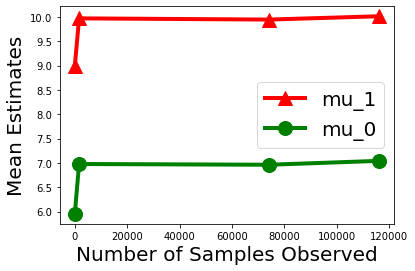

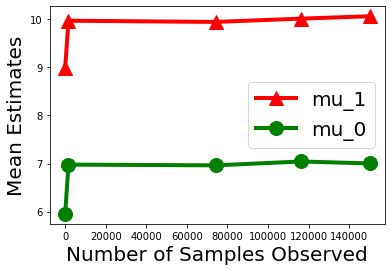

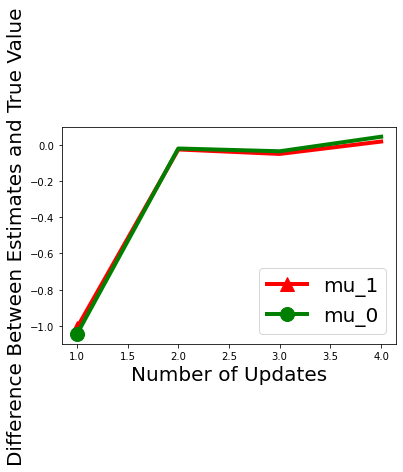

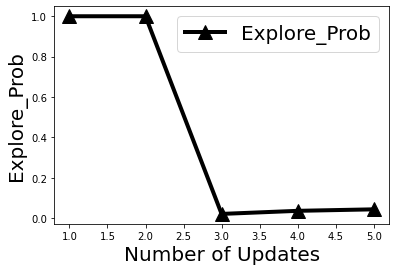

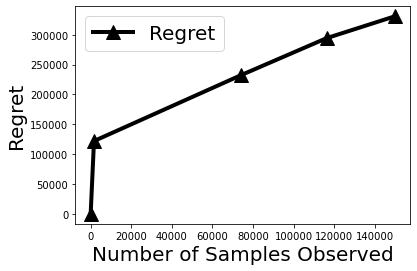

In [276]:
plt.plot(info_group1['RP_1'].dropna().index[:len(info_group1['RP_1'].dropna())-1],info_group1['RP_1'].dropna()[:len(info_group1['RP_1'].dropna())-1],
         lw=4,color='red',marker='^',ms=14, markevery=1,markerfacecolor='red')
plt.plot(info_group1['RP_0'].dropna().index[:len(info_group1['RP_0'].dropna())-1],info_group1['RP_0'].dropna()[:len(info_group1['RP_0'].dropna())-1],
         lw=4,color='green', marker='o',ms=14, markevery=1,markerfacecolor='green')
plt.legend(['mu_1','mu_0'],fontsize=20)
plt.xlabel('Number of Samples Observed', fontsize=20)
plt.ylabel('Mean Estimates', fontsize=20)
plt.show()

plt.plot(info_group1['RP_1'].dropna().index[:len(info_group1['RP_1'].dropna())],info_group1['RP_1'].dropna()[:len(info_group1['RP_1'].dropna())],
         lw=4,color='red',marker='^',ms=14, markevery=1,markerfacecolor='red')
plt.plot(info_group1['RP_0'].dropna().index[:len(info_group1['RP_0'].dropna())],info_group1['RP_0'].dropna()[:len(info_group1['RP_0'].dropna())],
         lw=4,color='green', marker='o',ms=14, markevery=1,markerfacecolor='green')
plt.legend(['mu_1','mu_0'],fontsize=20)
plt.xlabel('Number of Samples Observed', fontsize=20)
plt.ylabel('Mean Estimates', fontsize=20)
plt.show()

plt.plot(np.arange(1,len(info_group1['RP_1'].dropna()),1),info_group1['RP_1'].dropna()[:len(info_group1['RP_1'].dropna())-1]-mu_1_true_group1,
         lw=4,color='red',marker='^',ms=14, markevery=40,markerfacecolor='red')
plt.plot(np.arange(1,len(info_group1['RP_0'].dropna()),1),info_group1['RP_0'].dropna()[:len(info_group1['RP_0'].dropna())-1]-mu_0_true_group1,
         lw=4,color='green', marker='o',ms=14, markevery=40,markerfacecolor='green')
plt.legend(['mu_1','mu_0'],fontsize=20)
plt.xlabel('Number of Updates', fontsize=20)
plt.ylabel('Difference Between Estimates and True Value', fontsize=20)
plt.show()

plt.plot(np.arange(1,len(info_group1['Explore_Prob'].dropna())+1,1),info_group1['Explore_Prob'].dropna(),lw=4,color='black',marker='^',ms=14, markevery=1,markerfacecolor='black')
plt.legend(['Explore_Prob'],fontsize=20)
plt.xlabel('Number of Updates', fontsize=20)
plt.ylabel('Explore_Prob', fontsize=20)
plt.show()

plt.plot(info_group1['Regret'].dropna().index,info_group1['Regret'].dropna(),lw=4,color='black',marker='^',ms=14, markevery=1,markerfacecolor='black')
plt.legend(['Regret'],fontsize=20)
plt.xlabel('Number of Samples Observed', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.show()

In [195]:
%store
#%store -r

Stored variables and their in-db values:


In [277]:
info_group1.to_csv('pure_weightedregret.csv')
#object_name = pd.read_csv('file_name.csv')